# Antenna Position Measurement

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on three arms which are placed approximately 120 degrees apart.  This notebook will use measurements to infer the actual layout of the antennas.

Arm 1 will point geographically north (NOT magnetic). This arm forms the y-axis and will be used as a reference.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]

In [3]:
# pip install pandas
# pip install odfpy

import pandas as pd

#pd.read_excel('three_arm_measurements.ods', engine='odf')
cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('tart_rhodes_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      210.0
A 1      410.0
A 2      384.0
A 3      638.0
A 4      212.0
A 5      753.0
A 6     1261.0
A 7     1436.0
A 8     1707.0
A 9     1864.0
A 10    2199.0
A 11    2386.0
A 12     937.0
A 13    1084.0
A 14    1621.0
A 15    1924.0
A 16    2091.0
A 17    2408.0
A 18     914.0
A 19    1254.0
A 20    1575.0
A 21    1696.0
A 22    1856.0
A 23    2076.0
Name: 0, dtype: float64

In [4]:
n_ant = 24
m_0 = np.zeros(24)
m_ij = np.zeros((24,24))

radius = data.loc[0]

for i in range(24):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
m_ij

array([[   0.,  198.,  509.,  756.,  365.,  872., 1054., 1226., 1489.,
        1657., 1988., 2183., 1048., 1189., 1718., 2026., 2187., 2506.,
        1027., 1372., 1691., 1814., 1969., 2192.],
       [  nan,    0.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,    0.,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,    0.,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,    0.,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,

In [6]:
radius

A 0      210.0
A 1      410.0
A 2      384.0
A 3      638.0
A 4      212.0
A 5      753.0
A 6     1261.0
A 7     1436.0
A 8     1707.0
A 9     1864.0
A 10    2199.0
A 11    2386.0
A 12     937.0
A 13    1084.0
A 14    1621.0
A 15    1924.0
A 16    2091.0
A 17    2408.0
A 18     914.0
A 19    1254.0
A 20    1575.0
A 21    1696.0
A 22    1856.0
A 23    2076.0
Name: 0, dtype: float64

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [15]:
import requests
import json

def get_data(path):
    server = "https://tart.elec.ac.nz/rhodes"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

with open('calibration_data.json', "r") as f:
    data = f.read()
cal_json = json.loads(data)

current_pos = cal_json['ant_pos'] # get_pos()


current_pos = np.array(current_pos)


-21.0 205.0
-59.0 400.0
355.0 -138.0
593.0 -236.0
-165.0 -130.0
-584.0 -460.0
-183.0 1247.0
-208.0 1417.0
-246.0 1677.0
-270.0 1843.0
-318.0 2171.0
-347.0 2364.0
871.0 -345.0
1004.0 -397.0
1499.0 -594.0
1787.0 -709.0
1937.0 -769.0
2234.0 -887.0
-708.0 -558.0
-981.0 -775.0
-1233.0 -975.0
-1329.0 -1052.0
-1452.0 -1148.0
-1627.0 -1287.0


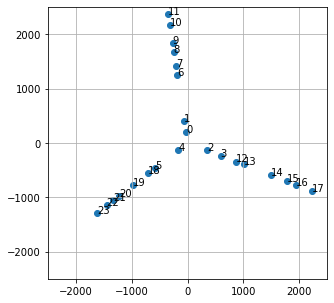

In [16]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(x,y)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_xlim(-2500,2500)
ax.set_ylim(-2500,2500)
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [17]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

def bounds():
    ret = [(0,0)]*48
    for i in range(24):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - 50, _x + 50)
        ret[i_y(i)] = (_y - 50, _y + 50)
    # x-component of the north arm set to zero.
    for i in [0,1,6,7,8,9,10,11]:
        xval = pos_i[i,0]
        ret[i_x(i)] = ( - 1, + 1)
    
    return ret

bnd = bounds()
    
center = [0,0]
def f(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

#for i in range(48):
#    print(bnd[i])
print(f(initial_guess))
res = minimize(f, initial_guess, bounds=bnd)
res

55769672.34583413


      fun: 51552730.27490376
 hess_inv: <48x48 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.67734239e+02,  7.45057469e-01,  0.00000000e+00,  5.91575630e+02,
        4.88757699e+02, -5.88596237e+01,  9.47713100e+02, -2.72691034e+02,
       -1.87754749e+02, -5.43892725e+01, -9.93161606e+02, -7.33136549e+02,
        7.45058060e-01,  2.26798072e+03,  7.45058060e-01,  2.60400546e+03,
        7.45058060e-01,  3.11810095e+03,  7.45058060e-01,  3.44592997e+03,
        7.45058060e-01,  4.09562747e+03,  7.45058060e-01,  4.47784629e+03,
        1.49682045e+03, -5.01423676e+02,  1.76057080e+03, -6.08711952e+02,
        2.74631305e+03, -1.01029793e+03,  3.32299409e+03, -1.24275586e+03,
        3.62251060e+03, -1.36345517e+03,  4.21558308e+03, -1.60112850e+03,
       -1.23977563e+03, -9.32811951e+02, -1.78292252e+03, -1.37090574e+03,
       -2.28735243e+03, -1.77398183e+03, -2.47734425e+03, -1.92820873e+03,
       -2.72321601e+03, -2.12120273e+03, -3.07339700e+03, -2.39911232e+03])
 

The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [18]:
pos = res.x.reshape((24,2))
pos

array([[-1.00000000e+00,  2.06125087e+02],
       [ 4.40464022e-01,  3.50000000e+02],
       [ 3.05000000e+02, -8.80000000e+01],
       [ 5.43000000e+02, -1.86000000e+02],
       [-1.15000000e+02, -8.00000000e+01],
       [-5.34000000e+02, -4.10000000e+02],
       [ 3.56396786e-01,  1.19700000e+03],
       [ 3.56396786e-01,  1.36700000e+03],
       [ 3.56396786e-01,  1.62700000e+03],
       [ 3.56396786e-01,  1.79300000e+03],
       [ 3.56396786e-01,  2.12100000e+03],
       [ 3.96782188e-01,  2.31400000e+03],
       [ 8.21000000e+02, -2.95000000e+02],
       [ 9.54000000e+02, -3.47000000e+02],
       [ 1.44900000e+03, -5.44000000e+02],
       [ 1.73700000e+03, -6.59000000e+02],
       [ 1.88700000e+03, -7.19000000e+02],
       [ 2.18400000e+03, -8.37000000e+02],
       [-6.58000000e+02, -5.08000000e+02],
       [-9.31000000e+02, -7.25000000e+02],
       [-1.18300000e+03, -9.25000000e+02],
       [-1.27900000e+03, -1.00200000e+03],
       [-1.40200000e+03, -1.09800000e+03],
       [-1.

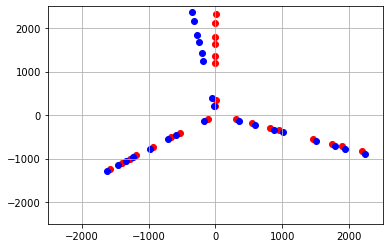

In [19]:
plt.scatter(pos[:,0], pos[:,1], color='red')
plt.scatter(pos_i[:,0], pos_i[:,1], color='blue')

plt.xlim(-2500,2500)
plt.ylim(-2500,2500)
plt.grid(True)
plt.show()

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [ ]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

In [ ]:
json_result = {}
json_result["antenna_positions"] = result.tolist()
print(json.dumps(json_result, indent=4, separators=(',', ': ')))

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file rhodes_antenna_positions.json
